In [9]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [10]:
# Définir la transformation des données, à la fois pour convenir au ResNet ("Resize(224)")
# et pour augmenter le dataset tout en l'équilibrant
data_transforms = transforms.Compose([
    # Suppression du bandeau vertical sur les images originelles
    transforms.Lambda(lambda img: transforms.functional.crop(img, top = 0, left = 0, height = img.height - 32, width =img.width)),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Utiliser un GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Chemins vers le dataset
data_dir_training = 'Dataset\Dataset\Training_data'

In [11]:
animal_classes = ['badger', 'bird', 'cat', 'fox', 'mouse', 'rabbit']

# Do only resizing and normalization
def create_dataset(data_dir, transform):
    transformed_images = []
    for class_name in animal_classes:
        for img in os.listdir(os.path.join(data_dir, class_name)):
            img_path = os.path.join(data_dir, class_name, img)
            image = Image.open(img_path)
            resized_img = transform(image)
            transformed_images.append((resized_img, class_name))
    return transformed_images

# Create datasets for each type of transformation
initial_training_dataset = create_dataset(data_dir_training, data_transforms)

In [14]:
class AnimalDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_tensor = self.dataframe[idx][0]
        label = self.dataframe[idx][1]

        # Convert label to torch.long
        label = torch.tensor(label, dtype=torch.long)

        return image_tensor, label

In [43]:
# Parameters
animal_classes = ['badger', 'bird', 'cat', 'fox', 'mouse', 'rabbit']
num_classes = len(animal_classes)
batch_size = 32
learning_rate = 0.001
num_epochs = 10

label_mapping = {label: idx for idx, label in enumerate(animal_classes)}
mapped_initial_dataset = [(tensor, label_mapping[label]) for tensor, label in initial_training_dataset]

initial_train_df, initial_val_df = train_test_split(mapped_initial_dataset, test_size=0.2)

# Create dataset objects
initial_train_dataset = AnimalDataset(dataframe=initial_train_df)
initial_val_dataset = AnimalDataset(dataframe=initial_val_df)

initial_train_loader = DataLoader(initial_train_dataset, batch_size=batch_size, shuffle=True)
initial_val_loader = DataLoader(initial_val_dataset, batch_size=batch_size, shuffle=False)

In [44]:
# Load pre-trained ResNet model and modify it
initial_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
initial_model.fc = nn.Linear(initial_model.fc.in_features, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(initial_model.parameters(), lr=learning_rate)

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
initial_model.to(device)

class_TP_initial = list(0. for i in range(num_classes))  # True Positives
class_FP_initial = list(0. for i in range(num_classes))  # False Positives
class_FN_initial = list(0. for i in range(num_classes))  # False Negatives

# Variables to store metrics per epoch for plotting
epoch_precision_initial = {i: [] for i in range(num_classes)}
epoch_recall_initial = {i: [] for i in range(num_classes)}
epoch_accuracy_initial = []

# Fine-tuning of the Resnet model
for epoch in range(num_epochs):
    initial_model.train()
    for images, labels in initial_train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = initial_model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Reset metrics for each epoch
    class_TP_initial = [0] * num_classes
    class_FP_initial = [0] * num_classes
    class_FN_initial = [0] * num_classes
    total, correct = 0, 0
    
    # Reset metrics for each epoch
    class_TP_initial = [0] * num_classes
    class_FP_initial = [0] * num_classes
    class_FN_initial = [0] * num_classes
    total, correct = 0, 0

    # Validation with precision and recall calculation
    initial_model.eval()
    with torch.no_grad():
        for images, labels in initial_val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = initial_model(images)
            _, predicted = torch.max(outputs, 1) 

            for i in range(labels.size(0)):
                label = labels[i]
                pred_label = predicted[i]
                if label == pred_label:
                    class_TP_initial[label] += 1
                else:
                    class_FP_initial[pred_label] += 1
                    class_FN_initial[label] += 1

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and store metrics per class
    for i in range(num_classes):
        precision = 100 * class_TP_initial[i] / (class_TP_initial[i] + class_FP_initial[i]) if (class_TP_initial[i] + class_FP_initial[i]) > 0 else 0
        recall = 100 * class_TP_initial[i] / (class_TP_initial[i] + class_FN_initial[i]) if (class_TP_initial[i] + class_FN_initial[i]) > 0 else 0
        epoch_precision_initial[i].append(precision)
        epoch_recall_initial[i].append(recall)

    # Store overall accuracy
    accuracy = 100 * correct / total
    epoch_accuracy_initial.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy}%')

KeyboardInterrupt: 

In [ ]:
# Plotting the metrics evolution
for i in range(num_classes):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epoch_precision_initial[i], label= animal_classes[i] + ' precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title(animal_classes[i] + ' precision Over Epochs (Initial data)')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epoch_recall_initial[i], label= animal_classes[i] + ' recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title(animal_classes[i] + ' recall over epochs (Initial data)')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epoch_accuracy_initial, label='Total Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Total Accuracy Over Epochs (Initial data)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Save the model
torch.save(initial_model.state_dict(), 'initial_data_animal_classifier_model.pth')

## Data augmentation

We don't have plenty of data, and especially for certain classes (unbalanced dataset). 

In order to correct that, we thought of **data augmentation**. This could solve both issues. 

*Data quantity* : data augmentation can increase the number of data available for training, enabling better learning and generalization.

*Unbalanced dataset* : by augmenting more frequently under-represented classes, this would also enable us to balance the dataset. 

**Augmented images need to be only used during training**.


In [21]:
def random_rotation(img): # called in images_random_affine
    # Choose a random angle from -10 to -5 or 5 to 10 degrees
    if random.random() > 0.5:
        angle = random.uniform(-10, -5)
    else:
        angle = random.uniform(5, 10)
    return transforms.functional.rotate(img, angle)

# Définir la transformation des données, à la fois pour convenir au ResNet ("Resize(224)")
# et pour augmenter le dataset tout en l'équilibrant
data_augmentation_transforms = {
    # Data augmentation techniques,
    'images_horizontally_flipped': transforms.Compose([
        transforms.Lambda(lambda img: transforms.functional.crop(img, top = 0, left = 0, height = img.height - 32, width =img.width)),
        transforms.RandomHorizontalFlip(1),
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'images_random_affine': transforms.Compose([
    transforms.Lambda(lambda img: transforms.functional.crop(img, top=0, left=0, height=img.height - 32, width=img.width)),
    transforms.Lambda(random_rotation),
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'images_random_perspective': transforms.Compose([
    transforms.Lambda(lambda img: transforms.functional.crop(img, top = 0, left = 0, height = img.height - 32, width =img.width)),
    transforms.RandomPerspective(distortion_scale=0.3, p=1),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Utiliser un GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Chemins vers le dataset
data_dir_training = 'Dataset\Dataset\Training_data'

In [22]:
class_occurences_training_initial = {
    'badger' : 0,
    'bird': 0,
    'cat': 0,
    'fox': 0,
    'mouse': 0,
    'rabbit': 0
}

for img in initial_training_dataset:
    class_occurences_training_initial[str(img[1])] += 1

In [23]:
class_occurences_max = max(class_occurences_training_initial.values())

class_augmentation_probabilities= {
animal: min(1, (class_occurences_max - class_occurences_training_initial[animal]) / (3 * class_occurences_training_initial[animal]))
    for animal in animal_classes
}

images_to_horizontally_flip = {}
images_to_random_affine = {}
images_to_random_perspective = {}

for class_name, probability in class_augmentation_probabilities.items():
    class_images = [img for img in os.listdir(os.path.join(data_dir_training, class_name)) if random.random() < probability]
    images_to_horizontally_flip[class_name] = class_images

for class_name, probability in class_augmentation_probabilities.items():
    class_images = [img for img in os.listdir(os.path.join(data_dir_training, class_name)) if random.random() < probability]
    images_to_random_affine[class_name] = class_images
    
for class_name, probability in class_augmentation_probabilities.items():
    class_images = [img for img in os.listdir(os.path.join(data_dir_training, class_name)) if random.random() < probability]
    images_to_random_perspective[class_name] = class_images

# Now, create datasets for each transformation with filtered images
def create_transformed_dataset(transform, images_list):
    transformed_images = []
    for class_name, images in images_list.items():
        for img in images:
            img_path = os.path.join(data_dir_training, class_name, img)
            image = Image.open(img_path)  # Load the image
            transformed_img = transform(image)
            transformed_images.append((transformed_img, class_name))
    return transformed_images

# Create datasets for each type of transformation
horizontal_flip_dataset = create_transformed_dataset(data_augmentation_transforms['images_horizontally_flipped'], images_to_horizontally_flip)
affine_transform_dataset = create_transformed_dataset(data_augmentation_transforms['images_random_affine'], images_to_random_affine)
perspective_transform_dataset = create_transformed_dataset(data_augmentation_transforms['images_random_perspective'], images_to_random_perspective)

In [24]:
# Function to convert a tensor to a PIL image
def tensor_to_pil(tensor):
    # Inverse normalization of the image
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    # Inverse normalization of the tensor
    inv_tensor = inv_normalize(tensor)
    # Clamp the image data to valid range (0-1)
    inv_tensor = inv_tensor.clamp(0, 1)
    # Convert to PIL Image
    pil_image = transforms.ToPILImage()(inv_tensor)
    return pil_image

In [25]:
def plot_images(num_images, dataset, delta):

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 4, 4))

    for i in range(num_images):
        image_tensor, class_name = dataset[delta*i] 
        image_pil = tensor_to_pil(image_tensor)
        # Plot each image
        ax = axes[i]
        ax.imshow(image_pil)
        ax.set_title(f"Class: {class_name}")
        ax.axis('off')

    plt.show()

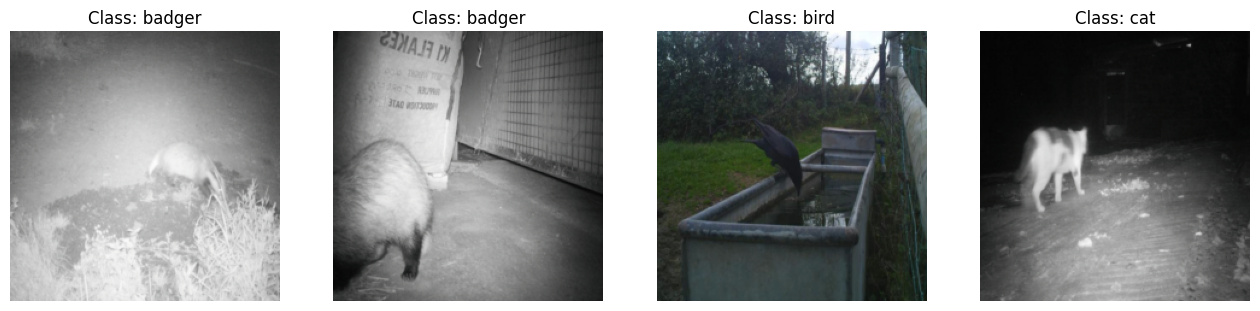

In [28]:
plot_images(4, horizontal_flip_dataset, 200)

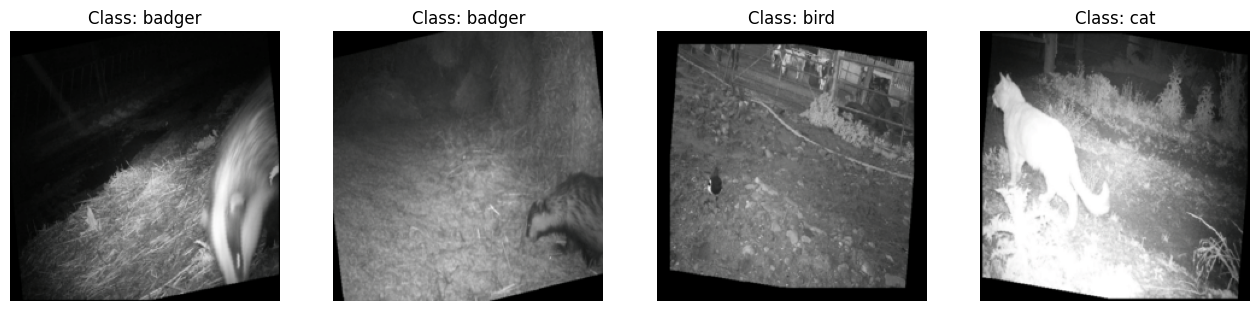

In [29]:
plot_images(4, affine_transform_dataset, 200)

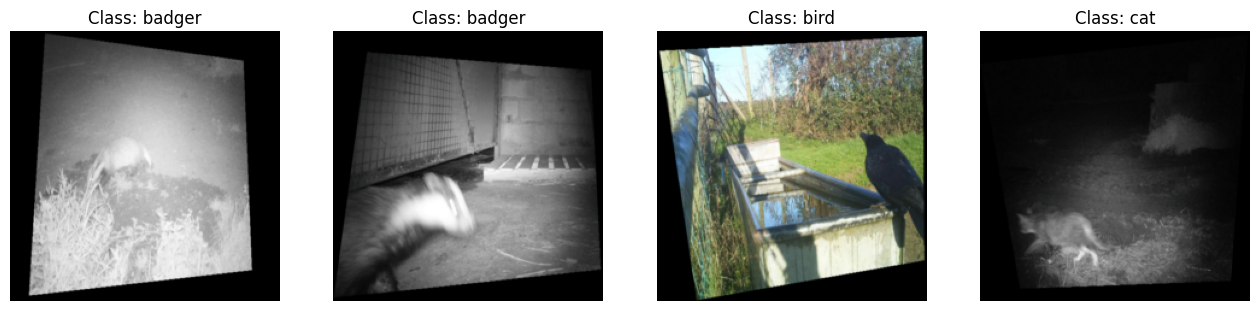

In [30]:
plot_images(4, perspective_transform_dataset, 200)

In [35]:
augmented_dataset = initial_training_dataset + horizontal_flip_dataset + affine_transform_dataset + perspective_transform_dataset

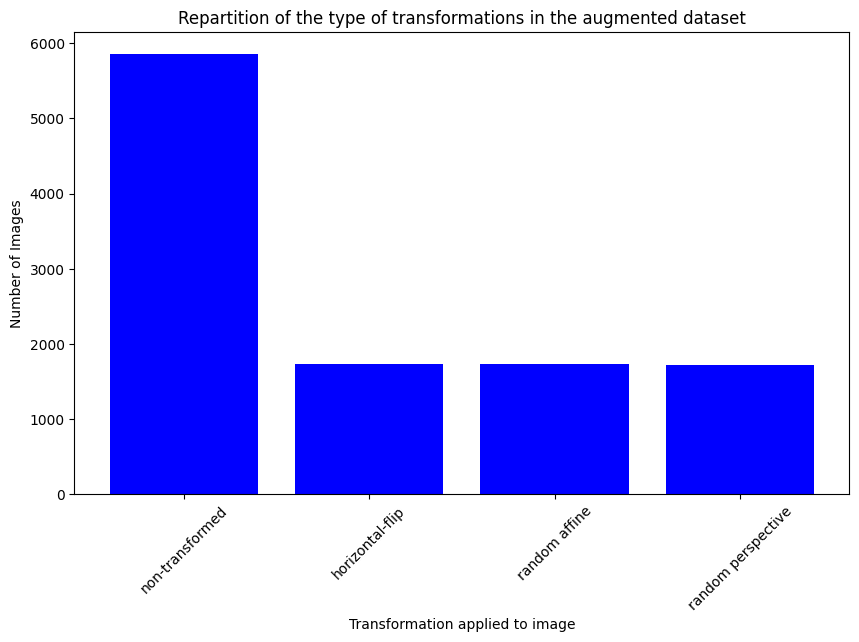

In [40]:
# Dataset lengths
transformations_occurences = {
    "non-transformed": len(initial_training_dataset),
    "horizontal-flip": len(horizontal_flip_dataset),
    "random affine": len(affine_transform_dataset),
    "random perspective": len(perspective_transform_dataset)
}

# Extracting dataset names and their lengths
datasets = list(transformations_occurences.keys())
lengths = list(transformations_occurences.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(datasets, lengths, color=['blue'])
plt.xlabel('Transformation applied to image')
plt.ylabel('Number of Images')
plt.title('Repartition of the type of transformations in the augmented dataset')
plt.xticks(rotation=45)
plt.show()

In [41]:
class_occurences_training_augmented = {
    'badger' : 0,
    'bird': 0,
    'cat': 0,
    'fox': 0,
    'mouse': 0,
    'rabbit': 0
}

for img in augmented_dataset:
    class_occurences_training_augmented[str(img[1])] += 1

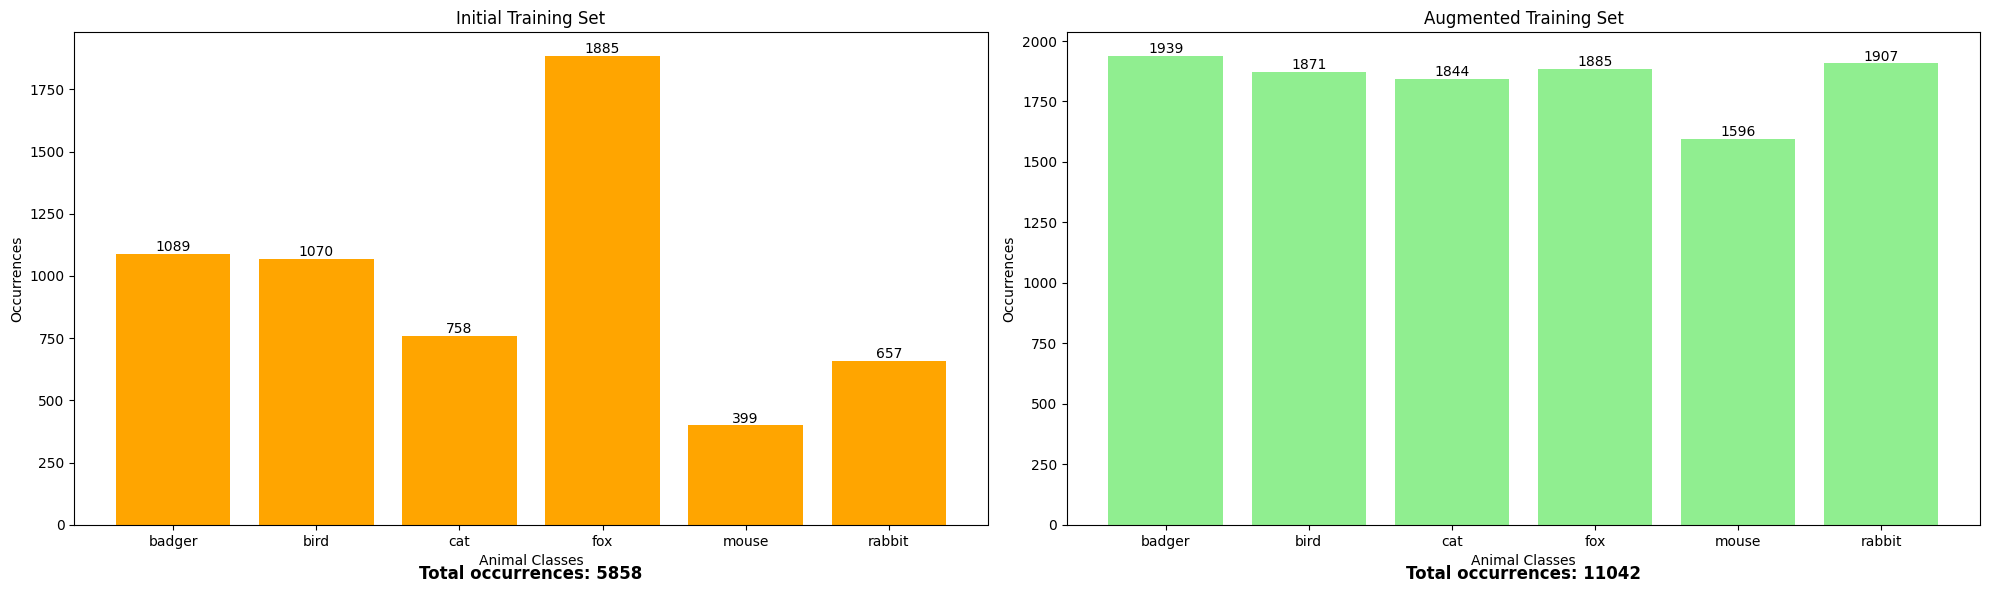

In [42]:
occurrences_initial = list(class_occurences_training_initial.values())
occurrences_augmented = list(class_occurences_training_augmented.values())

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

bars_initial = axes[0].bar(animal_classes, occurrences_initial, color='orange')
axes[0].set_title('Initial Training Set')
axes[0].set_xlabel('Animal Classes')
axes[0].set_ylabel('Occurrences')
total_initial = sum(occurrences_initial)
axes[0].text(0.5, -0.1, f'Total occurrences: {total_initial}', ha='center', va='center', 
             transform=axes[0].transAxes, fontsize=12, fontweight='bold')
for bar in bars_initial:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

bars_augmented = axes[1].bar(animal_classes, occurrences_augmented, color='lightgreen')
axes[1].set_title('Augmented Training Set')
axes[1].set_xlabel('Animal Classes')
axes[1].set_ylabel('Occurrences')
total_augmented = sum(occurrences_augmented)
axes[1].text(0.5, -0.1, f'Total occurrences: {total_augmented}', ha='center', va='center', 
             transform=axes[1].transAxes, fontsize=12, fontweight='bold')
for bar in bars_augmented:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.tight_layout()
plt.show()

In [46]:
# Convert labels to numerical values and ensure they are integers
label_mapping = {label: idx for idx, label in enumerate(animal_classes)}
mapped_augmented_dataset = [(tensor, label_mapping[label]) for tensor, label in augmented_dataset]

train_df, val_df = train_test_split(mapped_augmented_dataset, test_size=0.2)

# Create dataset objects
train_dataset = AnimalDataset(dataframe=train_df)
val_dataset = AnimalDataset(dataframe=val_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [27]:
# Load pre-trained ResNet model and modify it
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

class_TP = list(0. for i in range(num_classes))  # True Positives
class_FP = list(0. for i in range(num_classes))  # False Positives
class_FN = list(0. for i in range(num_classes))  # False Negatives

# Variables to store metrics per epoch for plotting
epoch_precision = {i: [] for i in range(num_classes)}
epoch_recall = {i: [] for i in range(num_classes)}
epoch_accuracy = []

# Fine-tuning of the Resnet model
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Reset metrics for each epoch
    class_TP = [0] * num_classes
    class_FP = [0] * num_classes
    class_FN = [0] * num_classes
    total, correct = 0, 0
    
    # Reset metrics for each epoch
    class_TP = [0] * num_classes
    class_FP = [0] * num_classes
    class_FN = [0] * num_classes
    total, correct = 0, 0

    # Validation with precision and recall calculation
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) 

            for i in range(labels.size(0)):
                label = labels[i]
                pred_label = predicted[i]
                if label == pred_label:
                    class_TP[label] += 1
                else:
                    class_FP[pred_label] += 1
                    class_FN[label] += 1

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and store metrics per class
    for i in range(num_classes):
        precision = 100 * class_TP[i] / (class_TP[i] + class_FP[i]) if (class_TP[i] + class_FP[i]) > 0 else 0
        recall = 100 * class_TP[i] / (class_TP[i] + class_FN[i]) if (class_TP[i] + class_FN[i]) > 0 else 0
        epoch_precision[i].append(precision)
        epoch_recall[i].append(recall)

    # Store overall accuracy
    accuracy = 100 * correct / total
    epoch_accuracy.append(accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy}%')

Epoch [1/10], Accuracy: 27.22323049001815%


KeyboardInterrupt: 

NameError: name 'epoch_precision' is not defined

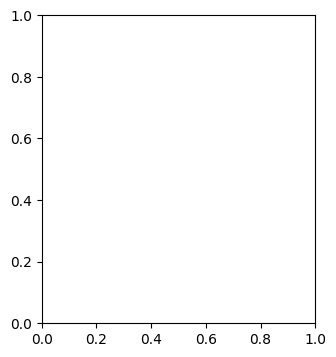

In [47]:
# Plotting the metrics evolution
for i in range(num_classes):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epoch_precision[i], label= animal_classes[i] + ' precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title(animal_classes[i] + ' precision Over Epochs (Augmented data)')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epoch_recall[i], label= animal_classes[i] + ' recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title(animal_classes[i] + ' recall over epochs (Augmented data)')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epoch_accuracy, label='Total Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Total Accuracy Over Epochs (Augmented data)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# Save the model
torch.save(model.state_dict(), 'augmented_data_animal_classifier_model.pth')